## Loading the Dataset

In [1]:
import numpy as np
import os
import h5py
from torch import nn
import torch.nn.functional as F


# Creating a directory containing .h5 files
#dir = "BraTS2020_training_data/content/data"
dir = "../../archive/BraTS2020_training_data/content/data"

# Create a list of all .h5 files in the directory
h5_files = [f for f in os.listdir(dir) if f.endswith('.h5')]
print(f"There are {len(h5_files)} .h5 files:\nSome example file names:{h5_files[:3]}")

# Open the first .h5 file in the list to inspect its contents
if h5_files:
    file_path = os.path.join(dir, h5_files[7])
    with h5py.File(file_path, 'r') as file:
        for key_name in file.keys():
            print(f"Shape of {key_name}:", file[key_name].shape)
else:
    print("No .h5 files found in the directory.")

There are 57195 .h5 files:
Some example file names:['volume_54_slice_149.h5', 'volume_95_slice_145.h5', 'volume_137_slice_59.h5']
Shape of image: (240, 240, 4)
Shape of mask: (240, 240, 3)


## Sample Images

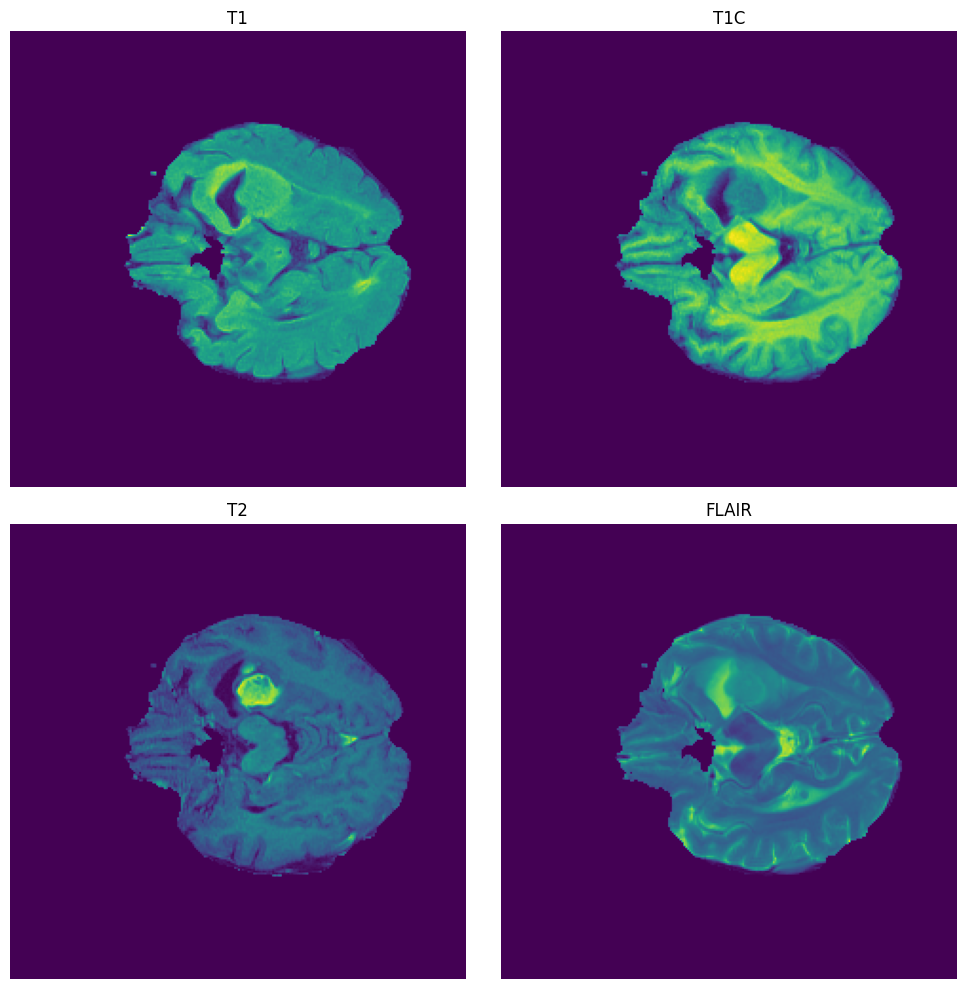

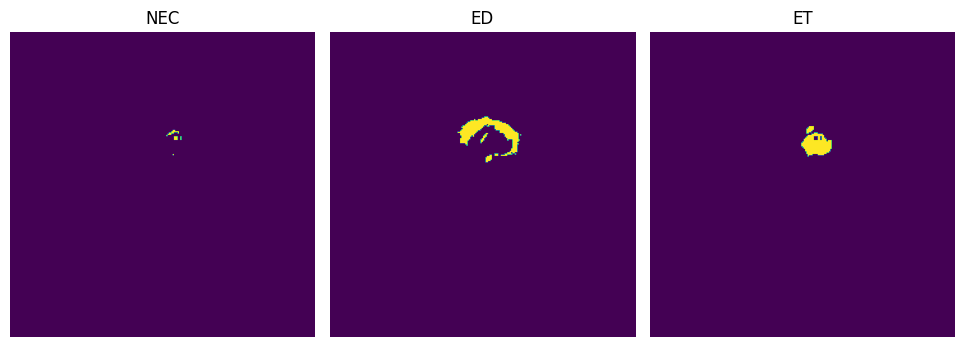

In [2]:
from figure_functions import *

sample_file_path = os.path.join(dir, h5_files[57001])
data = {}
with h5py.File(sample_file_path, 'r') as file:
    for key in file.keys():
        data[key] = file[key][()]

image = data['image'].transpose(2, 0, 1)
mask = data['mask'].transpose(2, 0, 1)


plot_image_channels(image)
plot_mask_channels(mask)

### Creating a Dataset and DataLoader

In [3]:
from torch.utils.data import Dataset, DataLoader

class NeuroScanCollection(Dataset):
    def __init__(self, paths_list, fixed_order=False):
        self.paths_list = paths_list
        if fixed_order:  # For consistent output during testing
            np.random.seed(0)
        np.random.shuffle(self.paths_list)
        
    def __len__(self):
        return len(self.paths_list)
    
    def __getitem__(self, index):
        # Retrieve h5 file, extract image and segmentation data
        path = self.paths_list[index]
        with h5py.File(path, 'r') as h5_file:
            img = h5_file['image'][()]
            seg = h5_file['mask'][()]
            
            # Change shape: (Height, Width, Channels) -> (Channels, Height, Width)
            img = img.transpose((2, 0, 1))
            seg = seg.transpose((2, 0, 1))
            
            # Normalize pixel values for each channel in the img
            for channel in range(img.shape[0]):
                channel_min = np.min(img[channel])
                img[channel] -= channel_min
                channel_max = np.max(img[channel]) + 1e-5
                img[channel] /= channel_max
            
            # Convert to tensors and normalize the entire img
            img_tensor = torch.tensor(img, dtype=torch.float32)
            seg_tensor = torch.tensor(seg, dtype=torch.float32)
            
        return img_tensor, seg_tensor

# Gather .h5 file paths from a directory
h5_paths = [os.path.join(dir, file) for file in os.listdir(dir) if file.endswith('.h5')]
np.random.seed(123)
np.random.shuffle(h5_paths)

# Divide the dataset into training and validation subsets (90%:10%)
division_index = int(0.9 * len(h5_paths))
training_paths = h5_paths[:division_index]
validation_paths = h5_paths[division_index:]

# Instantiate the datasets
training_set = NeuroScanCollection(training_paths)
validation_set = NeuroScanCollection(validation_paths, fixed_order=True)

# Define dataloaders for batching
training_loader = DataLoader(training_set, batch_size=5, shuffle=True)
validation_loader = DataLoader(validation_set, batch_size=5, shuffle=False)

# Iterator for generating test images
test_images_iterator = iter(DataLoader(validation_set, batch_size=1, shuffle=False))

# Check if dataloaders are functioning
for imgs, segs in training_loader:
    print("Training batch - Image tensor shape:", imgs.shape, "Segmentation tensor shape:", segs.shape)
    break
for imgs, segs in validation_loader:
    print("Validation batch - Image tensor shape:", imgs.shape, "Segmentation tensor shape:", segs.shape)
    break


Training batch - Image tensor shape: torch.Size([5, 4, 240, 240]) Segmentation tensor shape: torch.Size([5, 3, 240, 240])
Validation batch - Image tensor shape: torch.Size([5, 4, 240, 240]) Segmentation tensor shape: torch.Size([5, 3, 240, 240])


## Attention UNet

In [10]:
import torch.nn as nn
import torch.nn.functional as F

class EncoderBlock(nn.Module):
    def __init__(self, input_channels, output_channels, activation=nn.ReLU()):
        super().__init__()
        expand_ratio = 4
        
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=(7,7), stride=1, padding=3, groups=input_channels)
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.conv2 = nn.Conv2d(input_channels, expand_ratio * output_channels, kernel_size=(1,1), stride=1)
        self.conv3 = nn.Conv2d(expand_ratio * output_channels, output_channels, kernel_size=(1,1), stride=1)
        self.conv4 = nn.Conv2d(output_channels, output_channels, kernel_size=(7,7), stride=1, padding=3, groups=output_channels)
        self.bn4 = nn.BatchNorm2d(output_channels)
        self.conv5 = nn.Conv2d(output_channels, expand_ratio * output_channels, kernel_size=(1,1), stride=1)
        self.conv6 = nn.Conv2d(expand_ratio * output_channels, output_channels, kernel_size=(1,1), stride=1)
        self.activation = activation

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.conv5(out)
        out = self.activation(out)
        out = self.conv6(out)
        
        return out

class DecoderBlock(nn.Module):
    def __init__(self, input_channels, output_channels, activation=nn.ReLU()):
        super().__init__()
        expand_ratio = 4
        
        self.conv1 = nn.Conv2d(input_channels, input_channels, kernel_size=(7,7), stride=1, padding=3, groups=input_channels)
        self.bn1 = nn.BatchNorm2d(input_channels)
        self.conv2 = nn.Conv2d(input_channels, expand_ratio * input_channels, kernel_size=(1,1), stride=1)
        self.conv3 = nn.Conv2d(expand_ratio * input_channels, output_channels, kernel_size=(1,1), stride=1)
        self.conv4 = nn.Conv2d(output_channels, output_channels, kernel_size=(7,7), stride=1, padding=3, groups=output_channels)
        self.bn4 = nn.BatchNorm2d(output_channels)
        self.conv5 = nn.Conv2d(output_channels, expand_ratio * output_channels, kernel_size=(1,1), stride=1)
        self.conv6 = nn.Conv2d(expand_ratio * output_channels, output_channels, kernel_size=(1,1), stride=1)
        self.activation = activation

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.conv3(out) 
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.conv5(out)
        out = self.activation(out)
        out = self.conv6(out)
        
        return out


class AttentionBlock(nn.Module):
    def __init__(self, input_channels, activation=nn.ReLU()):
        super().__init__()
        self.query_conv = nn.Conv2d(input_channels, input_channels, kernel_size=(1,1), stride=1)
        self.key_conv = nn.Conv2d(input_channels, input_channels, kernel_size=(1,1), stride=2)
        self.attention_conv = nn.Conv2d(input_channels, 1, kernel_size=(1,1), stride=1)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        self.activation = activation
    
    def forward(self, q_input, k_input, v_input):
        q = self.query_conv(q_input)
        k = self.key_conv(k_input)   
        combined_attn = self.activation(q + k)
        attn_map = torch.sigmoid(self.attention_conv(combined_attn))
        upsampled_attn_map = self.upsample(attn_map)
        attn_scores = v_input * upsampled_attn_map
        return attn_scores

class Bottleneck(nn.Module):
    def __init__(self, base_filters, activation=nn.ReLU()):
        super().__init__()
        
        self.conv1 = nn.Conv2d(8 * base_filters, 8 * base_filters, kernel_size=(7,7), stride=1, padding=3, groups=8 * base_filters)
        self.bn1 = nn.BatchNorm2d(8 * base_filters)
        self.conv2 = nn.Conv2d(8 * base_filters, 4 * 8 * base_filters, kernel_size=(1,1), stride=1)
        self.conv3 = nn.Conv2d(4 * 8 * base_filters, 8 * base_filters, kernel_size=(1,1), stride=1)
        self.conv4 = nn.Conv2d(8 * base_filters, 8 * base_filters, kernel_size=(7,7), stride=1, padding=3, groups=8 * base_filters)
        self.bn4 = nn.BatchNorm2d(8 * base_filters)
        self.conv5 = nn.Conv2d(8 * base_filters, 4 * 8 * base_filters, kernel_size=(1,1), stride=1)
        self.conv6 = nn.Conv2d(4 * 8 * base_filters, 8 * base_filters, kernel_size=(1,1), stride=1)
        self.activation = activation

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.conv2(out)
        out = self.activation(out)
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.bn4(out)
        out = self.conv5(out)
        out = self.activation(out)
        out = self.conv6(out)
        
        return out

class AttentionUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Configuration
        input_channels = 4
        output_channels = 3
        base_filters = 32
        activation = nn.ReLU()
        
        # Up and downsampling methods
        self.pool = nn.MaxPool2d((2, 2), stride=2)
        self.upsample = nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_1 = EncoderBlock(input_channels, 1 * base_filters, activation)
        self.enc_2 = EncoderBlock(1 * base_filters, 2 * base_filters, activation)
        self.enc_3 = EncoderBlock(2 * base_filters, 4 * base_filters, activation)
        self.enc_4 = EncoderBlock(4 * base_filters, 8 * base_filters, activation)
        
        # Bottleneck
        self.bottleneck = Bottleneck(base_filters, activation)
        
        # Decoder
        self.dec_4 = DecoderBlock(8 * base_filters, 4 * base_filters, activation)
        self.dec_3 = DecoderBlock(4 * base_filters, 2 * base_filters, activation)
        self.dec_2 = DecoderBlock(2 * base_filters, 1 * base_filters, activation)
        self.dec_1 = DecoderBlock(1 * base_filters, 1 * base_filters, activation)
        
        # Output projection
        self.output_conv = nn.Conv2d(1 * base_filters,  output_channels, kernel_size=(1,1), stride=1, padding=0)
        
        # Attention blocks
        self.att_1 = AttentionBlock(1 * base_filters)
        self.att_2 = AttentionBlock(2 * base_filters)
        self.att_3 = AttentionBlock(4 * base_filters)
        self.att_4 = AttentionBlock(8 * base_filters)

    def forward(self, x):
        # Encoder
        enc1 = self.enc_1(x)
        x = self.pool(enc1)
        enc2 = self.enc_2(x)
        x = self.pool(enc2)
        enc3 = self.enc_3(x)
        x = self.pool(enc3)
        enc4 = self.enc_4(x)
        x = self.pool(enc4)
        
        # Bottleneck
        bottleneck_output = self.bottleneck(x)
        
        # Decoder
        x = self.upsample(bottleneck_output)
        att4 = self.att_4(bottleneck_output, enc4, enc4)
        x = torch.add(x, att4)
        
        dec3 = self.dec_4(x)
        x = self.upsample(dec3)
        att3 = self.att_3(dec3, enc3, enc3)
        x = torch.add(x, att3)
        
        dec2 = self.dec_3(x)
        x = self.upsample(dec2)
        att2 = self.att_2(dec2, enc2, enc2)
        x = torch.add(x, att2)
        
        dec1 = self.dec_2(x)
        x = self.upsample(dec1)
        att1 = self.att_1(dec1, enc1, enc1)
        x = torch.add(x, att1)
        
        x = self.dec_1(x)
        x = self.output_conv(x)
        return x


### Training Loop
In this training loop we increase the number of epochs to 25 and slightly increase the learning rate decay constant to accommodate for this greater number of epochs.

In [5]:
from train_model_and_save import *

lr = 0.001
epochs = 25
device = 'cuda' if torch.cuda.is_available() else 'cpu'
steps_per_epoch = 50
decay_rate=0.93

model = AttentionUNet()

train_epoch_losses, val_epoch_losses = train_network(model, training_loader, validation_loader, lr, epochs, device, steps_per_epoch, decay_rate, display_info=True)
torch.save(model.state_dict(), "AttentionUNet.pth")

In [6]:
plot_epoch_losses(train_epoch_losses, val_epoch_losses)

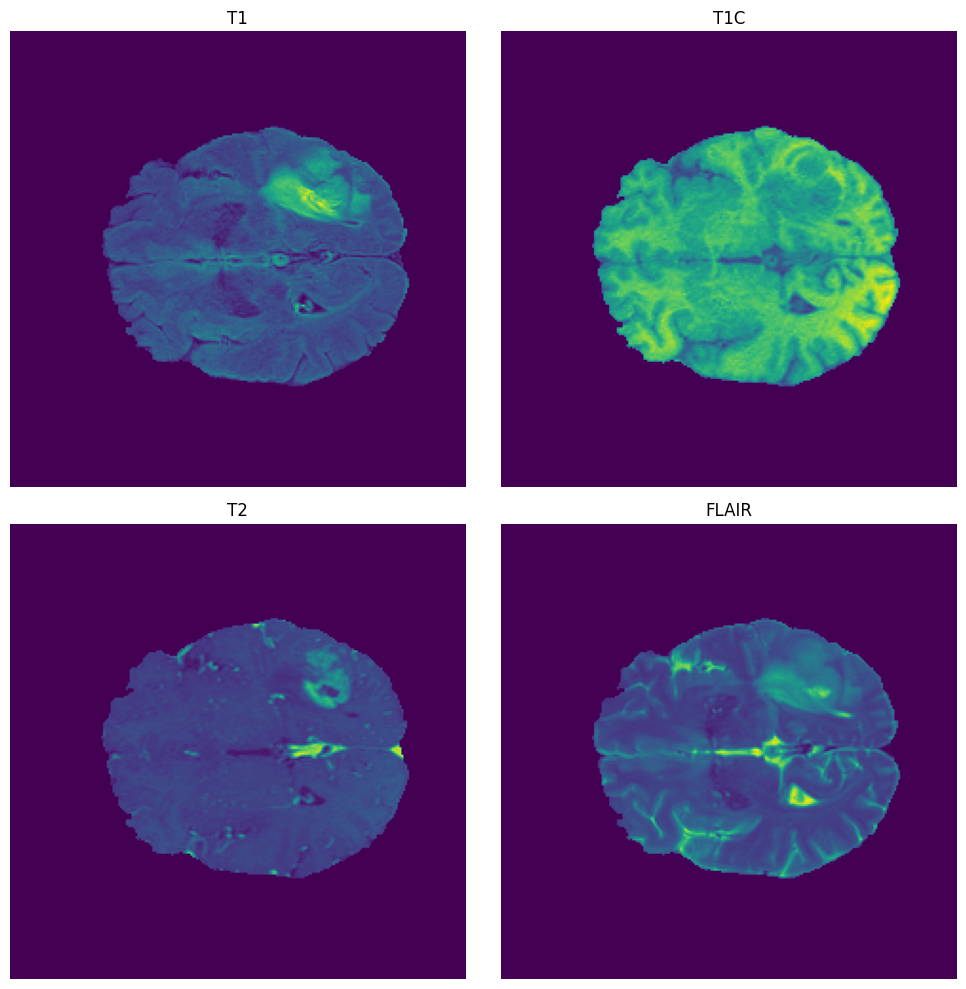

Prediction


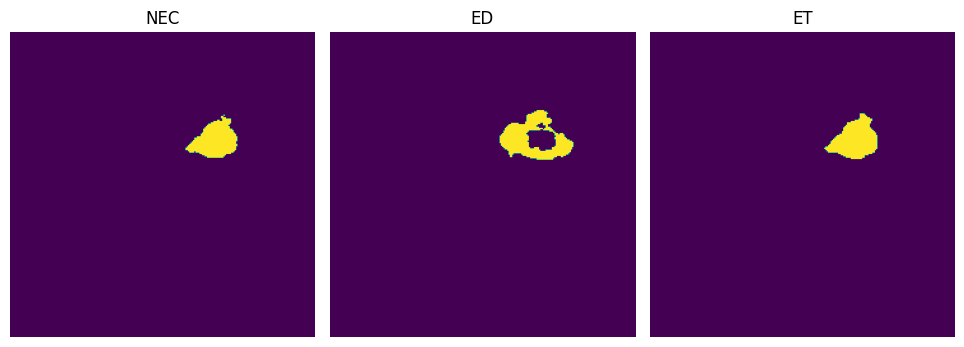

Ground Truth


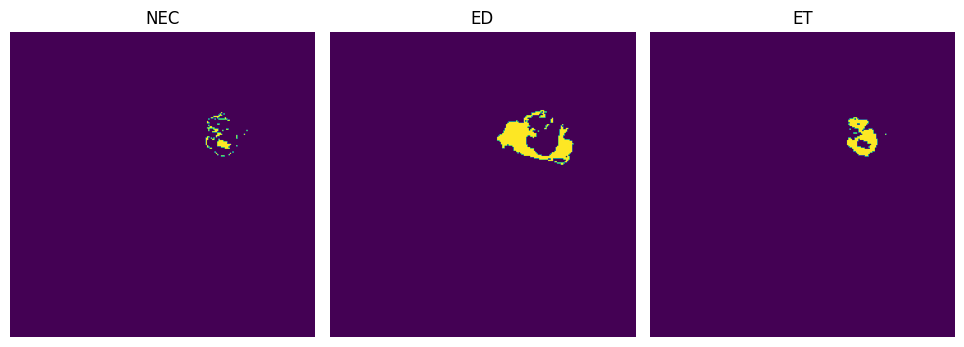

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = AttentionUNet()
model.load_state_dict(torch.load("AttentionUNet.pth", map_location=device))

test_img_iterator = iter(DataLoader(validation_set, batch_size=1, shuffle=True))
    
for count, tup in enumerate(test_img_iterator):
    if(count==9):
        test_input, test_target = next(test_images_iterator)
        visualize_sample_predictions(model, test_input, test_target, device)
        break

## Graphical representation of Attention

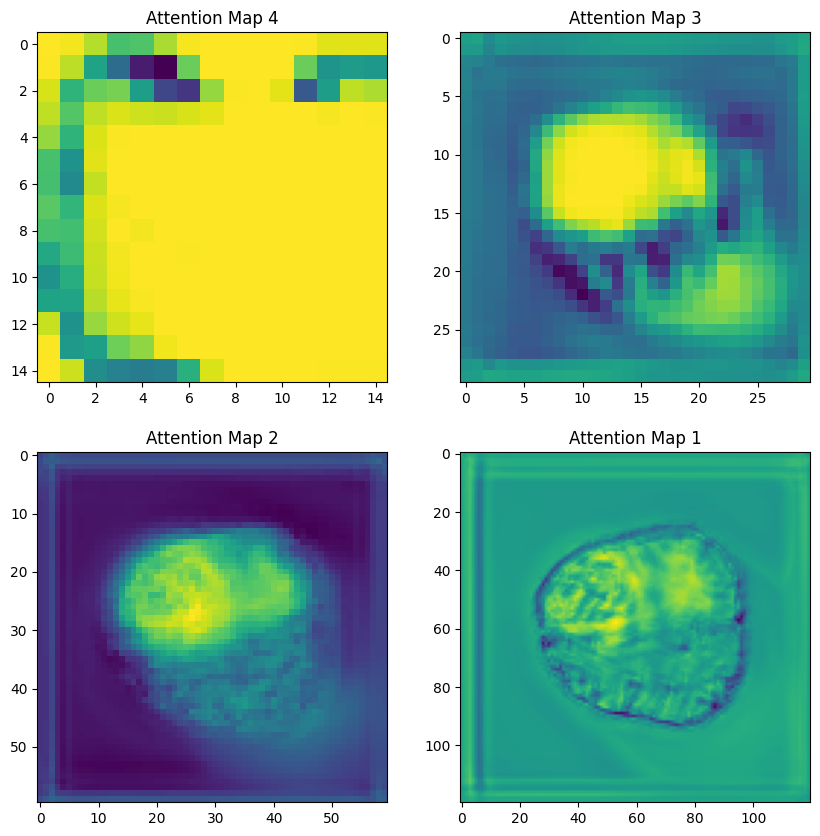

In [8]:
class AttentionBlock(nn.Module):
    def __init__(self, in_channels, activation=nn.ReLU()):
        super().__init__()
        self.query_conv     = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=1)
        self.key_conv       = nn.Conv2d(in_channels, in_channels, kernel_size=(1,1), stride=2)
        self.attention_conv = nn.Conv2d(in_channels, 1, kernel_size=(1,1), stride=1)
        
        self.upsample       = nn.UpsamplingBilinear2d(scale_factor=2)
        self.activation     = activation
    
    def forward(self, query, key, value):
        query = self.query_conv(query)
        key   = self.key_conv(key)
        
        combined_attention = self.activation(query + key)
        attention_map = torch.sigmoid(self.attention_conv(combined_attention))
        upsampled_attention_map = self.upsample(attention_map)
        attention_scores = value * upsampled_attention_map
        return attention_scores, attention_map  #### Redefining this block so we can extract the attention map
        

class AttentionVisualUNet(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Config
        in_channels  = 4   # Input images have 4 channels
        out_channels = 3   # Mask has 3 channels
        base_filters    = 32  # Scaled down from 64 in original paper
        activation   = nn.ReLU()
        
        # Up and downsampling methods
        self.downsample  = nn.MaxPool2d((2,2), stride=2)
        self.upsample    = nn.UpsamplingBilinear2d(scale_factor=2)
        
        # Encoder
        self.enc_1 = EncoderBlock(in_channels, 1*base_filters, activation)
        self.enc_2 = EncoderBlock(1*base_filters, 2*base_filters, activation)
        self.enc_3 = EncoderBlock(2*base_filters, 4*base_filters, activation)
        self.enc_4 = EncoderBlock(4*base_filters, 8*base_filters, activation)
        
        # Bottleneck
        self.bottleneck = Bottleneck(base_filters, activation)

        
        # Decoder
        self.dec_4 = DecoderBlock(8*base_filters, 4*base_filters, activation)
        self.dec_3 = DecoderBlock(4*base_filters, 2*base_filters, activation)
        self.dec_2 = DecoderBlock(2*base_filters, 1*base_filters, activation)
        self.dec_1 = DecoderBlock(1*base_filters, 1*base_filters, activation)
        
        # Output projection
        self.output_conv = nn.Conv2d(1*base_filters,  out_channels, kernel_size=(1,1), stride=1, padding=0)
        
        # Attention res blocks
        self.att_1 = AttentionBlock(1*base_filters)
        self.att_2 = AttentionBlock(2*base_filters)
        self.att_3 = AttentionBlock(4*base_filters)
        self.att_4 = AttentionBlock(8*base_filters)

    def forward(self, x):
        # Encoder
        enc_1 = self.enc_1(x)
        x     = self.downsample(enc_1)
        enc_2 = self.enc_2(x)
        x     = self.downsample(enc_2)
        enc_3 = self.enc_3(x)
        x     = self.downsample(enc_3)
        enc_4 = self.enc_4(x)
        x     = self.downsample(enc_4)
        
        # Bottleneck
        dec_4 = self.bottleneck(x)
        
        # Decoder
        x     = self.upsample(dec_4)
        att_4, map_4 = self.att_4(dec_4, enc_4, enc_4)
        x     = torch.add(x, att_4)
        
        dec_3 = self.dec_4(x)
        x     = self.upsample(dec_3)
        att_3, map_3 = self.att_3(dec_3, enc_3, enc_3)
        x     = torch.add(x, att_3)
        
        dec_2 = self.dec_3(x)
        x     = self.upsample(dec_2)
        att_2, map_2 = self.att_2(dec_2, enc_2, enc_2)
        x     = torch.add(x, att_2)
        
        dec_1 = self.dec_2(x)
        x     = self.upsample(dec_1)
        att_1, map_1 = self.att_1(dec_1, enc_1, enc_1)
        x     = torch.add(x, att_1)
        
        x     = self.dec_1(x)
        x     = self.output_conv(x)
        return x, map_4, map_3, map_2, map_1
    
# Build attention visualisation model
att_visual_unet = AttentionVisualUNet().to(device)
att_visual_unet.load_state_dict(torch.load('AttentionUNet.pth', map_location=device))

# Forward pass to get attention maps
x, map_4, map_3, map_2, map_1 = att_visual_unet(test_input.to(device))

# Plot atttention maps
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
for id, (ax, att_map) in enumerate(zip(axs.flatten(), [map_4, map_3, map_2, map_1])):
    power = 2**(3 - id)
    ax.imshow(att_map.detach().cpu().numpy().reshape(120//power,120//power))
    ax.set_title(f'Attention Map {4-id}')
    ax.grid(False)